Load the necessary libs

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Polygon
from geopandas import GeoSeries
import scipy.io as sio
import datetime

Define file names: varName + 
                  _Ann(ual)+
                  _8964Pts(grid points)_RCPs(2.6, 4.5, 6.0, 8.5)+
                  _50s80s(2050s,2080s)+
                  _Diffs(differences)+
                  _EC (reference data is ERA-Interim data for 1986-2005) 
data columns RCPs Percentiles of change (5,25,50,75,95), and periods (2050s and 2080s), Reference period

In [49]:
# in the historical data, we ignored Feb 29 in leap years
def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

In [50]:
# Variable names: mean temperature; maximum temperature, minimum temperature and precipiation
varNames = ['tas','tasmax','tasmin','pr']
varName='tas'

In [51]:
# read and map the variable for the period from 1979-2016
matfile = '../data/data/Historical/' + varName + '_ECMWF_8964X365X38.mat'  
datacontent=sio.loadmat(matfile)
data = datacontent['outputData']/10.0   # the data in matfile is integer (real value *10), it must be divided by 10
print(np.shape(data))
print(type(data))

(8964, 365, 38)
<class 'numpy.ndarray'>


In [52]:
print(data2map.columns)

Index(['values', 'id'], dtype='object')


In [53]:
# We simplified the base four maps and saved them as geojson format, user can use other version base maps
# read basemap data in geojson files
lakefile='../shapefiles/Lake_Arc_simplify.geojson'
Municipal = '../shapefiles/Municipal_Arc_simplify.geojson'
Ontario = '../shapefiles/Ontario_arc.geojson'
OnPolygon = '../shapefiles/polygon9864.geojson'

# Ontario boundary
ont=gpd.read_file(Ontario)

# the lakes within Ontario
lake=gpd.read_file(lakefile)

# municipals
muni=gpd.read_file(Municipal)

# merge grid polygon and the data for plotting spatial variation map
cmp='jet'
poly=gpd.read_file(OnPolygon)

(8964,)


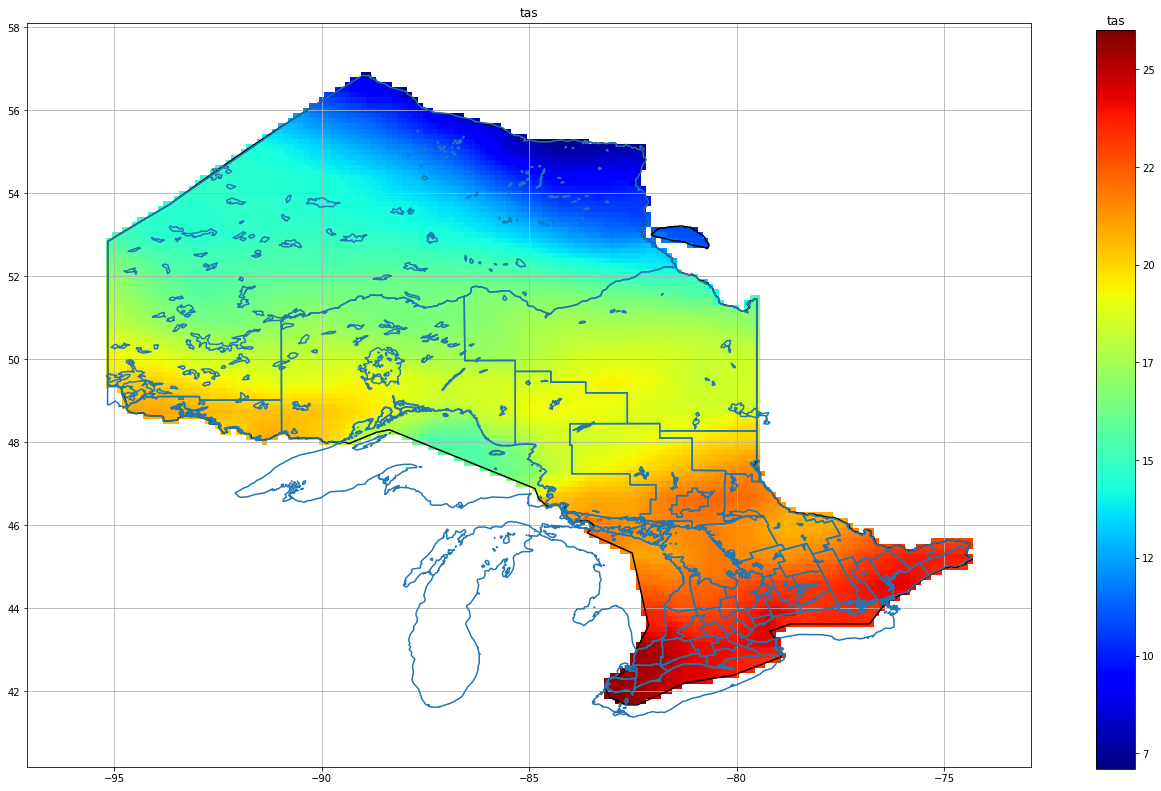

In [55]:
# display daily values on a map
# use can change this date
Year = 2016 # 1979-2016
Month = 7  # 1-12
Day = 28   # 

# extract the data on this specific day

theDate = datetime.date(Year,Month,Day)
# print(theDay)

theDayOfYear = theDate.timetuple().tm_yday
# print(theDayOfYear)

# our data does not include February 29 in leap year, so
if(is_leap_year(Year) and (theDayOfYear>59)):
    theDayOfYear=theDayOfYear-1
data_on_theDay = data[:,theDayOfYear-1,Year-1979]
print(np.shape(data_on_theDay))
data2map = pd.DataFrame(data_on_theDay,columns=['values'])
data2map['id']=pd.DataFrame(np.arange(1,8964))

# plot the background
p1=Polygon([(-96,41),(-74,41),(-74,57.3),(-96,57.3)])
g = GeoSeries(p1)
base=g.plot(color='white', edgecolor='white', figsize=(18,27))
ont.plot(ax=base, color='black', edgecolor='black')

# plot maps
lake.plot(ax=base)
muni.plot(ax=base)
polydata=poly.merge(data2map, on='id')
ax = polydata.plot(ax=base, column='values', colormap=cmp,vmin=min(polydata['values']),vmax=max(polydata['values']))

# setting legend
# thanks to: https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map
ax.set_title(varName)
ax.grid() 
fig = ax.get_figure()
# here, need trial-and-error to get [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)

cbax = fig.add_axes([0.95, 0.31, 0.03, 0.38])   
cbax.set_title(varName)

sm = plt.cm.ScalarMappable(cmap=cmp,norm=plt.Normalize(vmin=min(polydata['values']), vmax=max(polydata['values'])))
sm._A = []
fig.colorbar(sm, cax=cbax, format="%d")
plt.show()



Index(['ID', 'Longitude', 'Latitude'], dtype='object')
Index(['ID', 'Longitude', 'Latitude'], dtype='object')
(365, 38)
13879
13870


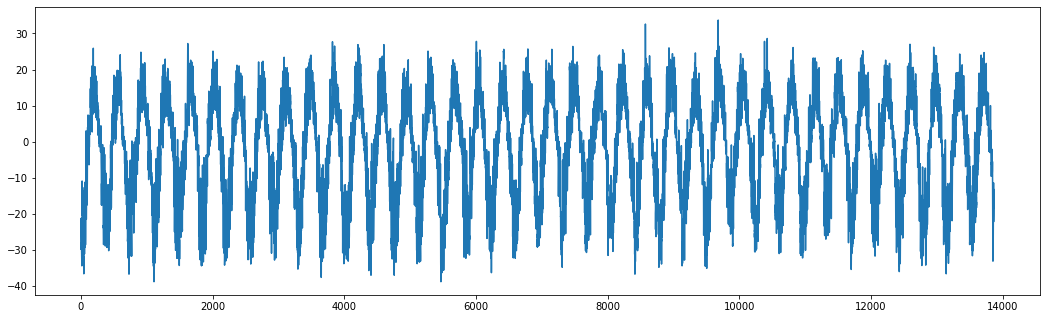

In [88]:
# following, we will plot time series at a specific location (latitude, longitude)
grids = pd.read_csv('../data/data/Historical/LAMPS_Ontario_8964Pts.csv')
print(grids.columns)
lon=-84
lat=54
grids1=grids[abs(grids.Latitude-lat)<0.06251]
print(grids1.columns)
grids2=grids1[abs(grids1.Longitude-lon)<0.06251]
if len(grids2) <1:
    print('sorry, your point is not in Ontario')
else:
    if len(grids2) ==1:
        timeseriesData= np.reshape(data[grids2.ID,:,:],(365,38))
        print(np.shape(timeseriesData))
    else:
        tmp=data[grids2.ID,:,:]
        print(np.shape(tmp))
        timeseriesData=np.reshape(np.mean(tmp,axis=0),(365,38))
fig2 = plt.figure(figsize=(18,18))
plt.subplot(3,1,1)
plt.plot(timeseriesData.T.flatten())

# following we generate date range and calculate monthly mean, annuan mean
start=datetime.datetime.strptime('01-01-1979','%d-%m-%Y')
end = datetime.datetime.strptime('31-12-2016','%d-%m-%Y')
dates = [start + datetime.timedelta(days=x) for x in range(0,(end-start).days)]
print(len(dates))        
print(365*38)    
 
    

